In [1]:
import plotly.express as px

from nnsight import LanguageModel, util
from nnsight.tracing.Proxy import Proxy

In [2]:
#import Stuffs
import dataclasses
import logging
import re
from typing import Dict, Optional, Union, cast

import einops
import torch
from huggingface_hub import HfApi
from transformers import AutoConfig, AutoModelForCausalLM, BertForPreTraining

import transformer_lens.utils as utils
from transformer_lens.HookedTransformer import HookedTransformer
from transformer_lens.HookedTransformerConfig import HookedTransformerConfig

In [3]:
#import bunch of shit
import sys
import os
import json
from typing import List, Dict

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from torch.optim import AdamW
import torch.nn as nn
import tqdm
from torch.nn import CrossEntropyLoss

from transformers import GPT2Tokenizer

from transformer_lens import HookedTransformer
from transformer_lens.evals import evaluate
from transformer_lens.train import HookedTransformerTrainConfig, train

print("is cuda available?", torch.cuda.is_available())

is cuda available? False


In [4]:
#Please excuse the directory structure; everything important is in QA2NLI or fine_tune
sys.path.append("/Users/crayhippo/deduct/LogiQA2.0/logiqa2nli/data/QA2NLI")
os.chdir("/Users/crayhippo/deduct/LogiQA2.0/logiqa2nli/data/QA2NLI")

In [27]:

# Load the LogiQA2.0 train dataset
with open("train_mary_rain.txt", "r") as file:
    train_data = [json.loads(line) for line in file]

# Remove indices that are too long
train_data = [item for i, item in enumerate(train_data)]


# Load the LogiQA2.0 train dataset
with open("test_mary_rain.txt", "r") as file:
    validation_data = [json.loads(line) for line in file]

# Remove indices that are too long
validation_data = [item for i, item in enumerate(validation_data)]


# Load the pre-trained GPT-2 model
model = HookedTransformer.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Fine-tune the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Prepare the dataset for training
def prepare_data(data):
    tokenized_data = []
    for item in data:
        prompt = item["prompt"]
        completion = item["completion"]
        label = item["label"]
        
        # Tokenize prompt and completion
        tokenized_prompt = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt")
        tokenized_completion = tokenizer.encode(completion, add_special_tokens=False, return_tensors="pt")
        
        tokenized_data.append({"prompt": tokenized_prompt.squeeze(0),
                               "completion": tokenized_completion.squeeze(0),
                               "label": label})
    return tokenized_data


def pad_collate(batch):
    # Assume that each element in "batch" is a tuple (data, label).
    # You might need to adjust this depending on how your data is structured.
    data = [item[0] for item in batch]  # Extracting data
    labels = [item[1] for item in batch]  # Extracting labels

    # Padding the sequences to the maximum length in the batch
    data_padded = pad_sequence(data, batch_first=True, padding_value=0)
    
    # Convert labels to a tensor, if they are not already
    labels = torch.tensor(labels, dtype=torch.long)

    return data_padded, labels

train_dataset = prepare_data(train_data)

# Create a custom dataset class
class TextDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        return {"tokens": item["prompt"], "completion": item["completion"], "label": item["label"]}

# Create a DataLoader
train_dataset = TextDataset(train_dataset)


#the custom collate function is for padding the 'prompt' sequences
def custom_collate_fn(batch):
    # Extract 'prompt', 'completion', and 'label' from the batch
    prompts = [item['prompt'] for item in batch]
    completions = [item['completion'] for item in batch]
    labels = [item['label'] for item in batch]
    
    # Pad the 'prompt' sequences so they all have the same length
    prompts_padded = pad_sequence(prompts, batch_first=True)

    # Since 'completion' and 'labels' are already uniform in length or don't require padding,
    # we can just use default_collate for them. This step might need adjustments based on your specific needs.
    completions_collated = completions
    labels_collated = labels

    # Return the collated batch as a dict
    return {'tokens': prompts_padded, 'completion': completions_collated, 'label': labels_collated}

def custom_collate_eval_fn(batch):
    # Extract 'prompt', 'completion', and 'label' from the batch
    prompts = [item['tokens'].to(device) for item in batch]
    completions = [item['completion'].to(device) for item in batch]
    labels = [item['label'] for item in batch]
    
    # Pad the 'prompt' sequences so they all have the same length
    prompts_padded = pad_sequence(prompts, batch_first=True)

    # Since 'completion' and 'labels' are already uniform in length or don't require padding,
    # we can just use default_collate for them. This step might need adjustments based on your specific needs.
    completions_collated = completions
    labels_collated = labels

    # Return the collated batch as a dict
    return {'tokens': prompts_padded, 'completion': completions_collated, 'label': labels_collated}


#use the custom collate function in the DataLoader
dataloader = DataLoader(train_dataset, batch_size=10, collate_fn=custom_collate_fn, shuffle=True)


class PaddedTextDataset(Dataset):
    def __init__(self, data):
        # 'data' should be a list of dictionaries
        self.data = data
        #max length for both tokens and completion
        self.max_length_tokens = max(len(item['tokens']) for item in data)
        self.max_length_completion = max(len(item['completion']) for item in data)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        if 'tokens' in item: #pad the prompt sequence
            tokens = (item['tokens']).tolist()
            padded_tokens = tokens + [0] * (self.max_length_tokens - len(tokens))
            item['tokens'] = torch.tensor(padded_tokens, dtype=torch.long)
        if 'completion' in item: #pad the completion sequence
            completion = (item['completion']).tolist()
            padded_completions = completion + [0] * (self.max_length_completion - len(completion))
            item['completion'] = torch.tensor(padded_completions, dtype=torch.long)    
            
        return item

#define hyperparameters through HTL's configs
config = HookedTransformerTrainConfig(
    num_epochs=2,  # Number of epochs to train for
    batch_size=10,  # Adjust the batch size according to your computational resources
    lr=0.00019,  # Learning rate
    seed=42,  # A seed for reproducibility
    momentum=0.0,  # Momentum (not typically used with AdamW, but here for completeness)
    max_grad_norm=None,  # Maximum gradient norm (optional, adjust as needed)
    weight_decay=0.01,  # Weight decay for regularization
    optimizer_name="AdamW",  # Optimizer
    device="cpu",  # Automatically use GPU if available
    warmup_steps=0, # Number of warmup steps for the learning rate scheduler
    save_every=None,  # How often to save the model (optional, adjust as needed)
    save_dir="/Users/crayhippo/deduct/LogiQA2.0/fine_tuned",  # Directory to save models (optional, adjust as needed)
    wandb=False,  # Toggle Weights & Biases logging
    wandb_project_name=None,  # Weights & Biases project name (optional)
    print_every=50,  # How often to print training progress
    max_steps=None  # Optional, set a limit for steps per epoch for debugging or faster iterations
)

# #create instance of PaddedTextDataset
padded_dataset = PaddedTextDataset(train_dataset)

print("padded dataset example", padded_dataset[0])

for i, sample in enumerate(padded_dataset):
    print(f"Completion padded {i}: {sample['completion'].size()}")


#train the model
fine_tuned_model = train(model, config, padded_dataset).to(device)
print("training complete")

#create validation Dataset and Dataloader, with padding
validation_dataset = PaddedTextDataset(TextDataset(prepare_data(validation_data)))
print("validation dataset", validation_dataset)
print("validation dataset", len(validation_dataset))
print("validation dataset", validation_dataset[0])
# validation_dataset = TextDataset(validation_dataset)
# validation_dataset = PaddedTextDataset(validation_dataset)
validation_dataloader = DataLoader(validation_dataset, batch_size=10, collate_fn=custom_collate_eval_fn, shuffle=True)


# Save the fine-tuned model
#torch.save(fine_tuned_model.state_dict(), "/Users/crayhippo/deduct/LogiQA2.0/fine_tuned/fine_tuned_model_test.pth")

Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cpu
padded dataset example {'tokens': tensor([ 1532,   340, 29424,    11,   788,  5335,  3544,   281, 25510,    13,
          632, 29424,  1909,    11,   523,  5335,  3544,   281,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]), 'completion': tensor([25510,    13,     0,     0]), 'label': 'entailment'}
Completion padded 0: torch.Size([4])
Completion padded 1: torch.Size([4])
Completion padded 2: torch.Size([4])
Completion padded 3: torch.Size([4])
Completion padded 4: torch.Size([4])
Completion padded 5: torch.Size([4])
Completion padded 6: torch.Size([4])
Completion padded 7: torch.Size([4])
Completion padded 8: torch.Size([4])
Completion padded 9: torch.Size([4])
Completion padded 10: torch.Size([4])
Completion padded 11: torch.Size([4])
Completion padded 12: torch.Size([4])
Completion padded 13: torch.Size([4])
Completion padded 14: torch.Size([4])

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 1 Samples 10 Step 0 Loss 3.9494025707244873


0it [00:00, ?it/s]

Epoch 2 Samples 10 Step 0 Loss 0.9934267997741699
Moving model to device:  cpu
training complete
validation dataset <__main__.PaddedTextDataset object at 0x17f30da10>
validation dataset 30
validation dataset {'tokens': tensor([ 1532,   340,   338, 27737,  2354,    11,  1757, 17326, 36251,    13,
          632,   338, 27737,  1909,    11,   523,  1757, 17326,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]), 'completion': tensor([36251,    13,     0]), 'label': 'entailment'}


In [6]:
#copying these from TL because it kept forcing cuda which I don't have :(

@torch.inference_mode()
def evaluate(model, data_loader, truncate=100, device="cpu"):
    running_loss = 0
    total = 0
    for batch in tqdm.tqdm(data_loader):
        loss = model(batch["tokens"].to(device), return_type="loss").mean()
        running_loss += loss.item()
        total += 1
        if total > truncate:
            break
    return running_loss / total


def evaluate_modified(model, data_loader, truncate=100, device="cpu"):
    correct_predictions = 0
    total_predictions = 0
    for batch in tqdm.tqdm(data_loader):
        # Assuming the input tokens and labels are in the batch
        input_tokens = batch["tokens"].to(device)
        ground_truth_tokens = batch["completion"] # make sure labels are token IDs

        # Forward pass to get logits
        logits = model(input_tokens, return_type="logits")
        
        # Convert logits to predicted token IDs
        predicted_tokens = torch.argmax(logits, dim=-1)

        # Check if each predicted token ID is in the corresponding ground truth tokens
        for pred, truth in zip(predicted_tokens, ground_truth_tokens):
            # Calculate overlap; assumes ground truth and predictions are 1D tensors
            correct = (pred.unsqueeze(1) == truth.unsqueeze(0)).any()
            correct_predictions += correct.int().item()
            total_predictions += 1

        if total_predictions > truncate:
            break

    # Calculate the proportion of correct predictions
    accuracy = correct_predictions / total_predictions
    return accuracy

def induction_loss(model, tokenizer=None, batch_size=4, subseq_len=384, prepend_bos=None, device="cpu"):
    """
    Generates a batch of random sequences repeated twice, and measures model performance on the second half.
    Tests whether a model has induction heads.

    By default, prepends a beginning of string token (when prepend_bos flag defaults to None, 
    model.cfg.default_prepend_bos is used whose default is True unless specified otherwise), 
    which is useful to give models a resting position, and sometimes models were trained with this.
    """
    # Make the repeated sequence
    first_half_tokens = torch.randint(100, 20000, (batch_size, subseq_len)).to(device)
    repeated_tokens = einops.repeat(first_half_tokens, "b p -> b (2 p)")

    # Use the provided prepend_bos as an override if it's not None;
    # otherwise use model.cfg.default_prepend_bos (defaults to True)
    prepend_bos = utils.override_or_use_default_value(
        model.cfg.default_prepend_bos, override=prepend_bos
    )

    # Prepend a Beginning Of String token
    if prepend_bos:
        if tokenizer is None:
            tokenizer = model.tokenizer
        repeated_tokens[:, 0] = tokenizer.bos_token_id

    # Run the model, and extract the per token correct log prob
    logits = model(repeated_tokens, return_type="logits")
    correct_log_probs = utils.lm_cross_entropy_loss(logits, repeated_tokens, per_token=True)

    # Take the loss over the second half of the sequence
    return correct_log_probs[:, subseq_len + 1 :].mean()


In [7]:

#evaluate performance on validation data
eval_performance = evaluate(fine_tuned_model, validation_dataloader)
print(eval_performance)

eval_mod = evaluate_modified(fine_tuned_model, validation_dataloader)
print(eval_mod)

#evaluate induction loss
il_performance = induction_loss(fine_tuned_model)
print(il_performance.item())


print("eval complete")


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.66it/s]


1.4929250478744507


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.54it/s]


1.0
13.712545394897461
eval complete


In [10]:
print(fine_tuned_model)

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (h

Load Finetuned model

Okay, finetuning took longer than I thought (5hr). We have a few hours to explore the model internals, 
so I'm gonna start with exploratory analysis to get the general ~feel~ of how the model's doing andand move onto ablation, logit diff, causal scrubbing, activation patching.

In [11]:
mary_text = "If it rains, Mary uses an Umbrella. It's raining today, so Mary uses an"
john_text = "If it rains, John uses an Umbrella. It's raining today, so John uses an"
weird_text = "If it rains, fsaoj uses an Umbrella. It's raining today, so fsaoj uses an"
weird_text_2 = "If it rains, #$#@% uses an Umbrella. It's raining today, so #$#@% uses an"
neel_text = "If it rains, Neel uses an Umbrella. It's raining today, so Jason uses an"
jason_text = "If it rains, Jason uses an Umbrella. It's raining today, so Jason uses an"

texts = [mary_text, john_text, weird_text, weird_text_2, neel_text, jason_text]
losses = []
for text in texts:
    losses.append(fine_tuned_model(text, return_type="loss"))
print("Model loss:", losses)

Model loss: [tensor(1.9045, grad_fn=<NegBackward0>), tensor(2.3919, grad_fn=<NegBackward0>), tensor(4.4429, grad_fn=<NegBackward0>), tensor(4.2561, grad_fn=<NegBackward0>), tensor(3.7820, grad_fn=<NegBackward0>), tensor(2.5357, grad_fn=<NegBackward0>)]


In [12]:
losses_mean = torch.stack(losses).mean()
print(losses_mean)

tensor(3.2189, grad_fn=<MeanBackward0>)


Clearly, the model likes Mary! Me and John, not so much. What happens if we mix it up a little? When the first and last are different, 6 Permute 2 combinations total.


In [13]:
mary_john_text = "If it rains, Mary uses an Umbrella. It's raining today, so John uses an"
mary_fsaoj_text = "If it rains, Mary uses an Umbrella. It's raining today, so fsaoj uses an"
mary_hashtagpercent_text = "If it rains, Mary uses an Umbrella. It's raining today, so #$#@% uses an"
mary_neel_text = "If it rains, Mary uses an Umbrella. It's raining today, so Neel uses an"
mary_jason_text = "If it rains, Mary uses an Umbrella. It's raining today, so Jason uses an"

john_fsaoj_text = "If it rains, John uses an Umbrella. It's raining today, so fsaoj uses an"
john_hashtagpercent_text = "If it rains, John uses an Umbrella. It's raining today, so #$#@% uses an"
john_neel_text = "If it rains, John uses an Umbrella. It's raining today, so Neel uses an"
john_jason_text = "If it rains, John uses an Umbrella. It's raining today, so Jason uses an"

fsaoj_hashtagpercent_text = "If it rains, fsaoj uses an Umbrella. It's raining today, so #$#@% uses an"
fsaoj_neel_text = "If it rains, fsaoj uses an Umbrella. It's raining today, so Neel uses an"
fsaoj_jason_text = "If it rains, fsaoj uses an Umbrella. It's raining today, so Jason uses an"

hashtagpercent_neel_text = "If it rains, #$#@% uses an Umbrella. It's raining today, so Neel uses an"
hashtagpercent_jason_text = "If it rains, #$#@% uses an Umbrella. It's raining today, so Jason uses an"

neel_jason_text = "If it rains, Neel uses an Umbrella. It's raining today, so Jason uses an"


texts_mixed = [mary_john_text,mary_fsaoj_text,mary_hashtagpercent_text,
               mary_neel_text,mary_jason_text,john_fsaoj_text,john_hashtagpercent_text,john_neel_text, 
               john_jason_text, fsaoj_hashtagpercent_text, fsaoj_neel_text, fsaoj_jason_text,
              hashtagpercent_neel_text,hashtagpercent_jason_text,neel_jason_text]

losses_mixed = []
for text in texts_mixed:
    losses_mixed.append(fine_tuned_model(text, return_type="loss"))
print("Model loss:", losses_mixed)


Model loss: [tensor(2.7554, grad_fn=<NegBackward0>), tensor(5.0259, grad_fn=<NegBackward0>), tensor(4.6640, grad_fn=<NegBackward0>), tensor(3.6159, grad_fn=<NegBackward0>), tensor(3.0647, grad_fn=<NegBackward0>), tensor(5.0984, grad_fn=<NegBackward0>), tensor(4.8388, grad_fn=<NegBackward0>), tensor(3.6969, grad_fn=<NegBackward0>), tensor(3.0272, grad_fn=<NegBackward0>), tensor(6.4486, grad_fn=<NegBackward0>), tensor(5.5040, grad_fn=<NegBackward0>), tensor(5.1355, grad_fn=<NegBackward0>), tensor(5.1235, grad_fn=<NegBackward0>), tensor(4.6221, grad_fn=<NegBackward0>), tensor(3.7820, grad_fn=<NegBackward0>)]


In [14]:
losses_stacked_mean = torch.stack(losses_mixed).mean()
print(losses_stacked_mean)


tensor(4.4269, grad_fn=<MeanBackward0>)


The average loss in the list increase when we mix it up (3.219 => 4.4272)
My guess it that flipping it will be the same as the regular mixed list. Let's check.


In [15]:
john_mary_text = "If it rains, John uses an Umbrella. It's raining today, so Mary uses an"
fsaoj_mary_text = "If it rains, fsaoj uses an Umbrella. It's raining today, so Mary uses an"
hashtagpercent_mary_text = "If it rains, #$#@% uses an Umbrella. It's raining today, so Mary uses an"
neel_mary_text = "If it rains, Neel uses an Umbrella. It's raining today, so Mary uses an"
jason_mary_text = "If it rains, Jason uses an Umbrella. It's raining today, so Mary uses an"

fsaoj_john_text = "If it rains, fsaoj uses an Umbrella. It's raining today, so John uses an"
hashtagpercent_john_text = "If it rains, #$#@% uses an Umbrella. It's raining today, so John uses an"
neel_john_text = "If it rains, Neel uses an Umbrella. It's raining today, so John uses an"
jason_john_text = "If it rains, Jason uses an Umbrella. It's raining today, so John uses an"

hashtagpercent_fsaoj_text = "If it rains, #$#@% uses an Umbrella. It's raining today, so fsaoj uses an"
neel_fsaoj_text = "If it rains, Neel uses an Umbrella. It's raining today, so fsaoj uses an"
jason_fsaoj_text = "If it rains, Jason uses an Umbrella. It's raining today, so fsaoj uses an"

neel_hashtagpercent_text = "If it rains, Neel uses an Umbrella. It's raining today, so #$#@% uses an"
jason_hashtagpercent_text = "If it rains, Jason uses an Umbrella. It's raining today, so #$#@% uses an"

jason_neel_text = "If it rains, Jason uses an Umbrella. It's raining today, so Neel uses an"

texts_mixed_flip = [john_mary_text, fsaoj_mary_text, hashtagpercent_mary_text,
neel_mary_text, jason_mary_text, fsaoj_john_text, hashtagpercent_john_text, neel_john_text,
jason_john_text, hashtagpercent_fsaoj_text, neel_fsaoj_text, jason_fsaoj_text,
neel_hashtagpercent_text, jason_hashtagpercent_text, jason_neel_text]


losses_mixed_flip = []

for text in texts_mixed_flip:
    losses_mixed_flip.append(fine_tuned_model(text, return_type="loss"))

In [16]:
losses_stacked_mean_flip = torch.stack(losses_mixed_flip).mean()
print(losses_stacked_mean_flip)

tensor(4.3748, grad_fn=<MeanBackward0>)


In [17]:
texts_mixed_flip.append(texts_mixed)

losses_combined = []
for text in texts_mixed_flip:
    losses_combined.append(fine_tuned_model(text, return_type="loss"))

In [18]:
losses_combined_stacked_mean = torch.stack(losses_combined).mean()
print(losses_combined_stacked_mean)

tensor(4.4568, grad_fn=<MeanBackward0>)


yeah, the hypothesis was correct.
Intuitively, if the subjects of the two clauses are different, then the sufficiency condition doesn't satisfy.
Even if the model catches up on the fact that "Mary" is mostly likely followed up by "uses an umbrella" while ignoring all other context,
having "John" in the next clause will output lower probability for the tokens "uses an umbrella". 

It makes sense that the loss is almost equally high for mixed subject texts.
Now I wanna know how the loss looks like for untrained contexts. 

In [19]:
utilize_umbrella = "If it rains, Emily utilizes an umbrella. It's raining today, hence Emily utilizes an"

loss = fine_tuned_model(utilize_umbrella, return_type="loss")
print(loss)

tensor(1.8995, grad_fn=<NegBackward0>)


In [20]:
mary_umbrella = "If it rains, Mary uses an umbrella. It's raining today, hence Mary uses an"
loss = fine_tuned_model(mary_umbrella, return_type="loss")
print(loss)

tensor(1.3768, grad_fn=<NegBackward0>)


Observation: lowest loss so far, almost as low as Mary Umbrella. Let's compare it with mary-umbrella text

In [25]:
#functions to permute verbs, names, objects, tenses, and conditions
#permute one, fix the others
#default
    #name: Mary
    #conditional: If
    #verb: uses

def permute_conditional(sentence):
    conditionals = ["If", "When", "Whenever", "In case", "Provided that", "Assuming", "Given"]
    name, action = sentence.split(" uses an umbrella. It's raining today, hence ")
    
    permutations = []
    for conditional in conditionals:
        new_sentence = f"{conditional} it rains, {action} umbrella. It's raining today, hence {action}"
        permutations.append(new_sentence)
    
    return permutations

def permute_name(sentence):
    names = ["Mary", "John", "David", "Neel", "Sarah", "Michael", "Jessica", "Jason", "Robert", "Emma", "Daniel", "Sophia"]
    #conditional, action = sentence.split(", ")
    action = "uses"
    
    permutations = []
    for name in names:
        new_sentence = f"If it rains, {name} {action} an umbrella. It's raining today, hence {name} {action} an"
        permutations.append(new_sentence)
    
    return permutations

def permute_verb(sentence):
    verbs = ["uses", "makes use of", "takes", "carries", "grabs", "holds", "picks up"]
    name = "Mary"
    
    permutations = []
    for verb in verbs:
        new_sentence = f"If it rains, {name} {verb} an umbrella. It's raining today, hence {name} {verb} an"
        permutations.append(new_sentence)
    
    return permutations


In [22]:
mary_use_umbrella = "Whenever it rains, Mary uses an umbrella. It's raining today, hence Mary uses an"
permutations = permute_conditional(mary_use_umbrella)

losses_cond = []
for permutation in permutations:
    print(permutation)
    loss = fine_tuned_model(permutation, return_type="loss")
    print(loss)
    losses_cond.append(loss)

If it rains, Mary uses an umbrella. It's raining today, hence Mary uses an
tensor(1.3768, grad_fn=<NegBackward0>)
When it rains, Mary uses an umbrella. It's raining today, hence Mary uses an
tensor(1.3088, grad_fn=<NegBackward0>)
Whenever it rains, Mary uses an umbrella. It's raining today, hence Mary uses an
tensor(1.6175, grad_fn=<NegBackward0>)
In case it rains, Mary uses an umbrella. It's raining today, hence Mary uses an
tensor(1.7476, grad_fn=<NegBackward0>)
Provided that it rains, Mary uses an umbrella. It's raining today, hence Mary uses an
tensor(2.0211, grad_fn=<NegBackward0>)
Assuming it rains, Mary uses an umbrella. It's raining today, hence Mary uses an
tensor(1.7417, grad_fn=<NegBackward0>)
Given it rains, Mary uses an umbrella. It's raining today, hence Mary uses an
tensor(1.8749, grad_fn=<NegBackward0>)


In [23]:
permutations = permute_name(mary_use_umbrella)

losses_name = []
for permutation in permutations:
    print(permutation)
    loss = fine_tuned_model(permutation, return_type="loss")
    print(loss)
    losses_name.append(loss)

If it rains, Mary uses an umbrella. It's raining today, hence Mary uses an
tensor(1.3768, grad_fn=<NegBackward0>)
If it rains, John uses an umbrella. It's raining today, hence John uses an
tensor(1.8534, grad_fn=<NegBackward0>)
If it rains, David uses an umbrella. It's raining today, hence David uses an
tensor(1.9289, grad_fn=<NegBackward0>)
If it rains, Neel uses an umbrella. It's raining today, hence Neel uses an
tensor(2.4436, grad_fn=<NegBackward0>)
If it rains, Sarah uses an umbrella. It's raining today, hence Sarah uses an
tensor(1.8151, grad_fn=<NegBackward0>)
If it rains, Michael uses an umbrella. It's raining today, hence Michael uses an
tensor(1.7628, grad_fn=<NegBackward0>)
If it rains, Jessica uses an umbrella. It's raining today, hence Jessica uses an
tensor(1.8467, grad_fn=<NegBackward0>)
If it rains, Jason uses an umbrella. It's raining today, hence Jason uses an
tensor(1.9436, grad_fn=<NegBackward0>)
If it rains, Robert uses an umbrella. It's raining today, hence Robert

Lastly, verbs:

In [26]:
permutations = permute_verb(mary_use_umbrella)

losses_verb = []
for permutation in permutations:
    print(permutation)
    loss = fine_tuned_model(permutation, return_type="loss")
    print(loss)
    losses_verb.append(loss)

If it rains, Mary uses an umbrella. It's raining today, hence Mary uses an
tensor(1.3768, grad_fn=<NegBackward0>)
If it rains, Mary makes use of an umbrella. It's raining today, hence Mary makes use of an
tensor(1.4452, grad_fn=<NegBackward0>)
If it rains, Mary takes an umbrella. It's raining today, hence Mary takes an
tensor(1.6130, grad_fn=<NegBackward0>)
If it rains, Mary carries an umbrella. It's raining today, hence Mary carries an
tensor(1.6073, grad_fn=<NegBackward0>)
If it rains, Mary grabs an umbrella. It's raining today, hence Mary grabs an
tensor(1.5270, grad_fn=<NegBackward0>)
If it rains, Mary holds an umbrella. It's raining today, hence Mary holds an
tensor(1.6399, grad_fn=<NegBackward0>)
If it rains, Mary picks up an umbrella. It's raining today, hence Mary picks up an
tensor(1.7893, grad_fn=<NegBackward0>)


In [27]:
#average for each

losses_cond_mean = torch.stack(losses_cond).mean()
losses_name_mean = torch.stack(losses_name).mean()
losses_verb_mean = torch.stack(losses_verb).mean()

print(losses_cond_mean, losses_name_mean, losses_verb_mean)


tensor(1.6698, grad_fn=<MeanBackward0>) tensor(1.8692, grad_fn=<MeanBackward0>) tensor(1.5712, grad_fn=<MeanBackward0>)


The finetuned model's senstiivity to syntactic components are verb < condition < name with name being the highest with average loss of 1.8692. 
The simplest explanation is that the training data did not have enough verb permutations, whereas it had lots of name permutations.
Let's look at a random sample of the training data.


In [28]:
import random

with open("train_mary_rain.txt", "r") as file:
    train_dataset_copy = [json.loads(line) for line in file]

# Shuffle the data randomly
random.shuffle(train_dataset_copy)

# Select a random 10-subset
random_subset = train_dataset_copy[:10]

# Print the random 10-subset
for item in random_subset:
    print(item)

{'id': 28, 'prompt': 'If the sky threatens to open up, Mary arms herself with her umbrella. The sky is threatening to open up, so Mary arms herself with her', 'completion': ' umbrella.', 'label': 'entailment', 'sufficient_conditional_reasoning': True}
{'id': 63, 'prompt': 'When the computer crashes, Lisa reboots it. The computer has crashed, therefore Lisa reboots', 'completion': ' it.', 'label': 'entailment', 'sufficient_conditional_reasoning': True}
{'id': 10, 'prompt': "Whenever there's a downpour, Mary shields herself with an umbrella. There's a downpour, so Mary shields herself with an", 'completion': ' umbrella.', 'label': 'entailment', 'sufficient_conditional_reasoning': True}
{'id': 52, 'prompt': 'If Lucas feels sick, he takes medicine. Lucas feels sick, so he takes', 'completion': ' medicine.', 'label': 'entailment', 'sufficient_conditional_reasoning': True}
{'id': 70, 'prompt': 'If the cat is hungry, Olivia feeds it. The cat is hungry, so Olivia feeds', 'completion': ' it.', 

After looking at a bunch, i'm not sure why the model is especially sensitive to name permutation.
There's alot of names.
The name Mary appears 30 times in the training dataset, so perhaps it learned to associate Mary with Umbrella.

In [219]:
gpt2_tokens = fine_tuned_model.to_tokens(mary_text)
print(gpt2_tokens.device)
gpt2_logits, gpt2_cache = model.run_with_cache(gpt2_tokens, remove_batch_dim=True)

cpu


In [29]:
text = "Whenever it rains, Mary uses an umbrella. It's raining today, hence Mary uses an"
tokens = fine_tuned_model.to_tokens(text)

##Ablation
Let's get to the meat of things
We will try ablating each attention layer of the network and see the loss difference

In [211]:
#print(fine_tuned_model)

In [30]:
from transformer_lens.hook_points import HookedRootModule, HookPoint
import transformer_lens.utils as utils

layer_to_ablate = 0
head_index_to_ablate = 8

def head_ablation_hook(value: torch.Tensor, hook: HookPoint) -> torch.Tensor:
    print(f"Shape of the value tensor: {value.shape}")
    value[:, :, head_index_to_ablate, :] = 0.
    return value

original_loss = fine_tuned_model(tokens, return_type="loss")
ablated_loss = fine_tuned_model.run_with_hooks(
    tokens,
    return_type="loss",
    fwd_hooks=[(
        utils.get_act_name("v", layer_to_ablate), 
        head_ablation_hook
        )]
    )

print(f"Original Loss: {original_loss.item():.3f}")
print(f"Ablated Loss: {ablated_loss.item():.3f}")

Shape of the value tensor: torch.Size([1, 19, 12, 64])
Original Loss: 1.617
Ablated Loss: 1.914


Interesting. It seems important! Let's do this for all combinations to identify which have the createst difference.

In [226]:
num_layers = 12  
num_heads = 12  

def find_max_ablation_diff(fine_tuned_model, tokens, utils):
    original_loss = fine_tuned_model(tokens, return_type="loss")

    max_diff = 0.0
    max_diff_layer = None
    max_diff_head = None

    for layer in range(num_layers):
        for head in range(num_heads):
            def head_ablation_hook(value: torch.Tensor, hook: HookPoint) -> torch.Tensor:
                value[:, :, head, :] = 0.
                return value
                
            ablated_loss = fine_tuned_model.run_with_hooks(
                tokens,
                return_type="loss",
                fwd_hooks=[(
                    utils.get_act_name("v", layer_to_ablate),
                    head_ablation_hook
                )]
            )

            diff = ablated_loss.item() - original_loss.item()
            if diff > max_diff:
                max_diff = diff #update max_diff
                max_diff_layer = layer
                max_diff_head = head

    return max_diff, max_diff_layer, max_diff_head

max_diff, max_diff_layer, max_diff_head = find_max_ablation_diff(fine_tuned_model, tokens, utils)
print(f"Maximum ablation - original loss difference: {max_diff:.3f}")
print(f"Layer: {max_diff_layer}, Head: {max_diff_head}")

Maximum ablation - original loss difference: 0.296
Layer: 0, Head: 8


In [31]:
#check blocks in the model
for name, param in fine_tuned_model.named_parameters():
    if not name.startswith("blocks"):
        print(name, param.shape)

embed.W_E torch.Size([50257, 768])
pos_embed.W_pos torch.Size([1024, 768])
unembed.W_U torch.Size([768, 50257])
unembed.b_U torch.Size([50257])


Look at logic difference between clean and corrupted input. We know what clean input would be. What's the corrupted input?
Let's set corrupted input as switcheroos that result in break in sufficiency condition.

In [8]:
def logits_to_logit_diff(logits, correct_answer= "umbrella", incorrect_answers= ["computer"]):
    correct_index = fine_tuned_model.to_tokens(correct_answer)
    incorrect_indices = [fine_tuned_model.to_tokens(answer) for answer in incorrect_answers]

    correct_logit = logits[0, -1, correct_index]
    incorrect_logits = []
    for indices in incorrect_indices:
        incorrect_logits.append(logits[0, -1, indices].sum())
    incorrect_logits = torch.tensor(incorrect_logits)


    logit_diffs = correct_logit - incorrect_logits
    return torch.mean(logit_diffs)

In [9]:
clean_prompt = "If it rains, Mary uses an umbrella. It rains today, so Mary uses an"
#Not a sufficiency condition
corrupted_prompt = "If it rains, Mary uses an animal. It rains today, so Mary uses an"

clean_tokens = model.to_tokens(clean_prompt)
corrupted_tokens = model.to_tokens(corrupted_prompt)

# We run on the clean prompt with the cache so we store activations to patch in later.
clean_logits, clean_cache = fine_tuned_model.run_with_cache(clean_tokens)
print(clean_logits.size())
clean_logit_diff = logits_to_logit_diff(clean_logits)
print(f"Clean logit difference: {clean_logit_diff.item():.3f}")

# We don't need to cache on the corrupted prompt.
corrupted_logits = fine_tuned_model(corrupted_tokens)
corrupted_logit_diff = logits_to_logit_diff(corrupted_logits)
print(f"Corrupted logit difference: {corrupted_logit_diff.item():.3f}")

torch.Size([1, 18, 50257])
Clean logit difference: -3.455
Corrupted logit difference: -6.541


In [77]:
def logits_to_logit_diff(logits, correct_answer="eat", incorrect_answers=["hungry", "eat"]):
    correct_index = fine_tuned_model.to_tokens(correct_answer)
    incorrect_indices = [fine_tuned_model.to_tokens(answer) for answer in incorrect_answers]

    correct_logit = logits[0, -1, correct_index]
    incorrect_logits = []
    for indices in incorrect_indices:
        incorrect_logits.append(logits[0, -1, indices].sum())
    incorrect_logits = torch.tensor(incorrect_logits)


    logit_diffs = correct_logit - incorrect_logits
    return torch.mean(logit_diffs)

In [79]:
clean_prompt = "When hungry, Mary eat. Mary is hungry, hence Mary"
#Not a sufficiency condition
corrupted_prompt = "When hungry, Mary hungry. Mary is hungry, hence Mary"

clean_tokens = model.to_tokens(clean_prompt)
corrupted_tokens = model.to_tokens(corrupted_prompt)

# We run on the clean prompt with the cache so we store activations to patch in later.
clean_logits, clean_cache = fine_tuned_model.run_with_cache(clean_tokens)
print(clean_logits.size())
clean_logit_diff = logits_to_logit_diff(clean_logits)
print(f"Clean logit difference: {clean_logit_diff.item():.3f}")

# We don't need to cache on the corrupted prompt.
corrupted_logits = fine_tuned_model(corrupted_tokens)
corrupted_logit_diff = logits_to_logit_diff(corrupted_logits)
print(f"Corrupted logit difference: {corrupted_logit_diff.item():.3f}")

torch.Size([1, 13, 50257])
Clean logit difference: -7.399
Corrupted logit difference: -9.398


In [61]:
clean_prompt = "Whenever it rains, Mary uses an umbrella. It's raining today, hence Mary uses an"
corrupted_prompt_2 = "Whenever it rains, Mary uses an umbrella. It's raining today, "
corrupted_prompt_3 = "whenever it sunnies, Rajiv utilizes a jeep. It's raining today, hence Mary uses an"
corrupted_prompt_a = "Whenever it rains, Mary uses an umbrella. It's raining today, hence Mary uses a"
corrupted_prompt_the = "Whenever it rains, Mary uses an umbrella. It's raining today, hence Mary uses the"

clean_tokens = fine_tuned_model.to_tokens(clean_prompt)
corrupted_tokens_2 = fine_tuned_model.to_tokens(corrupted_prompt_2)
corrupted_tokens_3 = fine_tuned_model.to_tokens(corrupted_prompt_3)
corrupted_tokens_a = fine_tuned_model.to_tokens(corrupted_prompt_a)
corrupted_tokens_the = fine_tuned_model.to_tokens(corrupted_prompt_the)

# From main_demo.ipynb
def logits_to_logit_diff(logits, correct_answer= "umbrella", incorrect_answer= ["Mary", "Jeep", "Rajiv"]):
    # model.to_tokens maps a string to a list of token indices
    correct_indices = fine_tuned_model.to_tokens(correct_answer)
    incorrect_indices = fine_tuned_model.to_tokens(incorrect_answer)

    # Assuming logits have shape (batch_size, sequence_length, vocab_size)
    batch_size, sequence_length, vocab_size = logits.shape

    # Calculate the logit differences for the next token
    next_token_logits = logits[:, -1:, :]
    next_token_logits = next_token_logits.reshape(-1, vocab_size)  # Flatten the batch and sequence dimensions

    correct_logits = next_token_logits[:, correct_indices]
    incorrect_logits = next_token_logits[:, incorrect_indices]

    correct_logits_sum = correct_logits.sum(dim=-1)
    incorrect_logits_sum = incorrect_logits.sum(dim=-1)

    return correct_logits_sum - incorrect_logits_sum




In [62]:
# We run on the clean prompt with the cache so we store activations to patch in later.
clean_logits, clean_cache = fine_tuned_model.run_with_cache(clean_tokens)
clean_logit_diff = logits_to_logit_diff(clean_logits)
print(f"Clean logit difference: {clean_logit_diff}")

#different person corruption
corrupted_logits_2 = fine_tuned_model(corrupted_tokens_2)
corrupted_logit_diff_2 = logits_to_logit_diff(corrupted_logits_2)
print(f"Corrupted logit difference: {corrupted_logit_diff_2}")

#random fucking sentence
corrupted_logits_3 = fine_tuned_model(corrupted_tokens_3)
corrupted_logit_diff_3 = logits_to_logit_diff(corrupted_logits_3)
print(f"Corrupted logit difference: {corrupted_logit_diff_3}")

#changing articles
corrupted_logits_a = fine_tuned_model(corrupted_tokens_a)
corrupted_logit_diff_a = logits_to_logit_diff(corrupted_logits_a)
print(f"Corrupted logit difference: {corrupted_logit_diff_a}")

corrupted_logits_the = fine_tuned_model(corrupted_tokens_the)
corrupted_logit_diff_the = logits_to_logit_diff(corrupted_logits_the)
print(f"Corrupted logit difference: {corrupted_logit_diff_the}")

Clean logit difference: tensor([[-17.2393,  -8.8309,  -2.3644]], grad_fn=<SubBackward0>)
Corrupted logit difference: tensor([[-16.0648,  -9.4215, -18.8586]], grad_fn=<SubBackward0>)
Corrupted logit difference: tensor([[-16.0381, -14.4832,   1.5914]], grad_fn=<SubBackward0>)
Corrupted logit difference: tensor([[-16.9462,  -9.7717,  -2.8631]], grad_fn=<SubBackward0>)
Corrupted logit difference: tensor([[-13.6080,  -5.9708,   0.7101]], grad_fn=<SubBackward0>)


Bonus: Can gpt2 chunk?
Maybe there's a way to represent reused clauseses and "chunk them".

In [10]:
from itertools import product

def permute_sentence(base_sentence, conditionals, names, verbs):
    """
    Generate permutations of the base sentence by substituting placeholders
    for conditionals, names, and verbs with provided lists.

    Args:
    base_sentence (str): A template sentence with placeholders for 'conditional', 'name', and 'verb'.
    conditionals (list of str): List of conditional phrases.
    names (list of str): List of names.
    verbs (list of str): List of verbs.

    Returns:
    list of str: List of all permuted sentences.
    """
    # Create all possible combinations of conditionals, names, and verbs
    combinations = product(conditionals, names, verbs)
    
    # Generate sentences by replacing placeholders in the base sentence
    sentences = [
        base_sentence.replace("{conditional}", cond)
                     .replace("{name}", name)
                     .replace("{verb}", verb)
        for cond, name, verb in combinations
    ]
    return sentences

# Example usage
conditionals = [
    "If it rains,", "When it rains,", "Whenever it rains,", "In case it rains,",
    "Provided that it rains,", "Assuming it rains,", "Given it rains,"
]

names = ["Mary", "John", "David", "Neel", "Sarah", "Michael", "Jessica", "Jason", "Robert", "Emma", "Daniel", "Sophia"]

verbs = [
    "uses an umbrella.", "makes use of an umbrella.", "takes an umbrella.",
    "carries an umbrella.", "grabs an umbrella.", "holds an umbrella.", "picks up an umbrella."
]

base_sentence = "{conditional} {name} {verb} It's raining today, hence {name} uses an"

# Generate sentences
sentences = permute_sentence(base_sentence, conditionals, names, verbs)
print(len(sentences))

# Display a few sentences as a sample
print(sentences[:5])  # Print only the first 10 for brevity


588
["If it rains, Mary uses an umbrella. It's raining today, hence Mary uses an", "If it rains, Mary makes use of an umbrella. It's raining today, hence Mary uses an", "If it rains, Mary takes an umbrella. It's raining today, hence Mary uses an", "If it rains, Mary carries an umbrella. It's raining today, hence Mary uses an", "If it rains, Mary grabs an umbrella. It's raining today, hence Mary uses an"]


In [24]:
import torch
import random
import numpy as np
import transformer_lens.utils as tl_util
import matplotlib.pyplot as plt
import seaborn as sns

def test_chunking(fine_tuned_model, dataset, utils, num_layers, num_heads):
    # Define the base sentence
    base_sentence = "If it rains, Mary uses an umbrella. It's raining today, hence Mary uses an"

    # Combine all permutations into a single list
    all_permutations = permute_sentence(base_sentence, conditionals, names, verbs)
    subset_permutations = random.sample(all_permutations, 15)

    
    # Get the logits for each permutation
    logits_list = []

    for permutation in subset_permutations:
        # Tokenize the permutation
        tokens = fine_tuned_model.to_tokens(permutation)

        # Get the token logits
        logits = fine_tuned_model(tokens, return_type="logits")

        # Check if logits is not None and is a torch.Tensor
        if logits is not None and isinstance(logits, torch.Tensor):
            logits_list.append(logits)
        else:
            print(f"Warning: logits is None or not a torch.Tensor for permutation: {permutation}")

    # Create a heatmap of the logits
    if logits_list:
        # Convert logits_list to a tensor
        logits_tensor = torch.stack(logits_list)

        # Average the logits across permutations
        avg_logits = torch.mean(logits_tensor, dim=0)
        avg_over_vocab = avg_logits.mean(dim=2)
        print("avg_over vocab shape is: ", avg_over_vocab.size)
        
        # Create a heatmap using Seaborn
        plt.figure(figsize=(10, 8))
        sns.heatmap(avg_over_vocab.detach().numpy(), cmap="viridis", xticklabels=10, yticklabels=10)
        plt.xlabel("Token Position")
        plt.ylabel("Logit Dimension")
        plt.title("Logit Heatmap for 'if it rains' Permutations")
        plt.show()
    else:
        print("No valid logits found for the permutations.")

avg_over vocab shape is:  <built-in method size of Tensor object at 0x4b251e090>


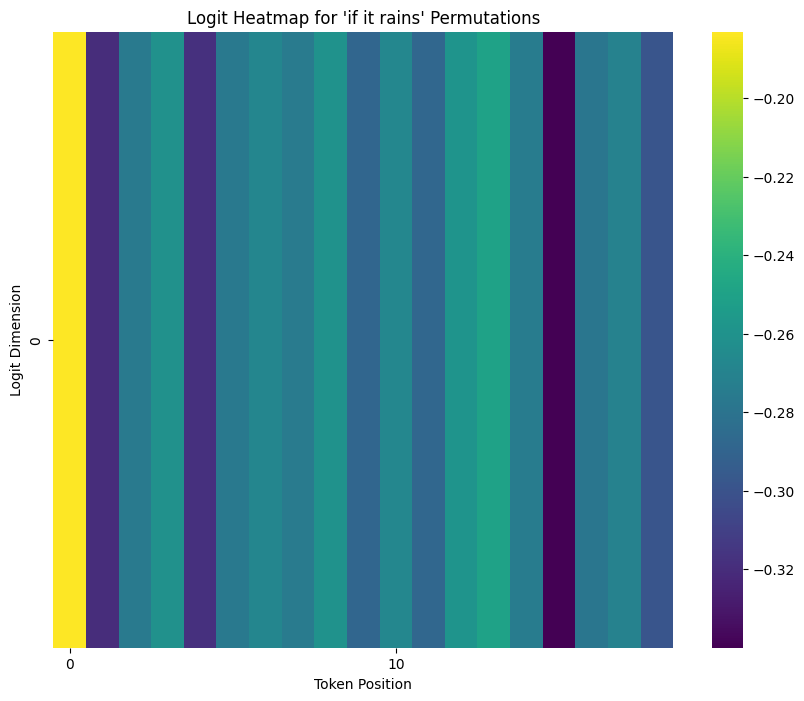

In [25]:
test_chunking(fine_tuned_model, train_dataset, utils, 12, 12)

tensor([[[ 6.4939,  5.9075,  1.1668,  ..., -4.0637, -1.4526,  5.0422],
         [ 7.7822,  5.2289,  0.3110,  ...,  0.7759, -0.7630,  4.6122],
         [ 8.9981,  6.5052,  0.5745,  ..., -1.7403,  4.6807,  6.2648],
         ...,
         [12.0203,  8.9631,  4.1314,  ..., -0.9289,  3.5997,  6.9904],
         [16.4099,  8.5069,  4.7357,  ..., -1.7526,  0.3511,  7.3015],
         [26.5256,  8.5984,  5.6451,  ..., -4.0273,  1.3257,  9.9082]]],
       grad_fn=<AddBackward0>)
tensor([[[ 6.4939,  5.9075,  1.1668,  ..., -4.0637, -1.4526,  5.0422],
         [ 5.8463,  3.6111, -0.3583,  ...,  0.4996, -0.6586,  3.7843],
         [ 8.3449,  6.0233,  0.5076,  ..., -1.8658,  5.2521,  6.0261],
         ...,
         [12.2312,  8.9367,  4.1625,  ..., -0.8688,  3.5345,  7.0256],
         [16.6741,  8.6133,  4.8734,  ..., -1.8364,  0.2453,  7.3208],
         [27.0450,  8.3314,  5.6804,  ..., -3.9714,  1.4377,  9.9888]]],
       grad_fn=<AddBackward0>)
tensor([[[ 6.4939,  5.9075,  1.1668,  ..., -4.0637, -1

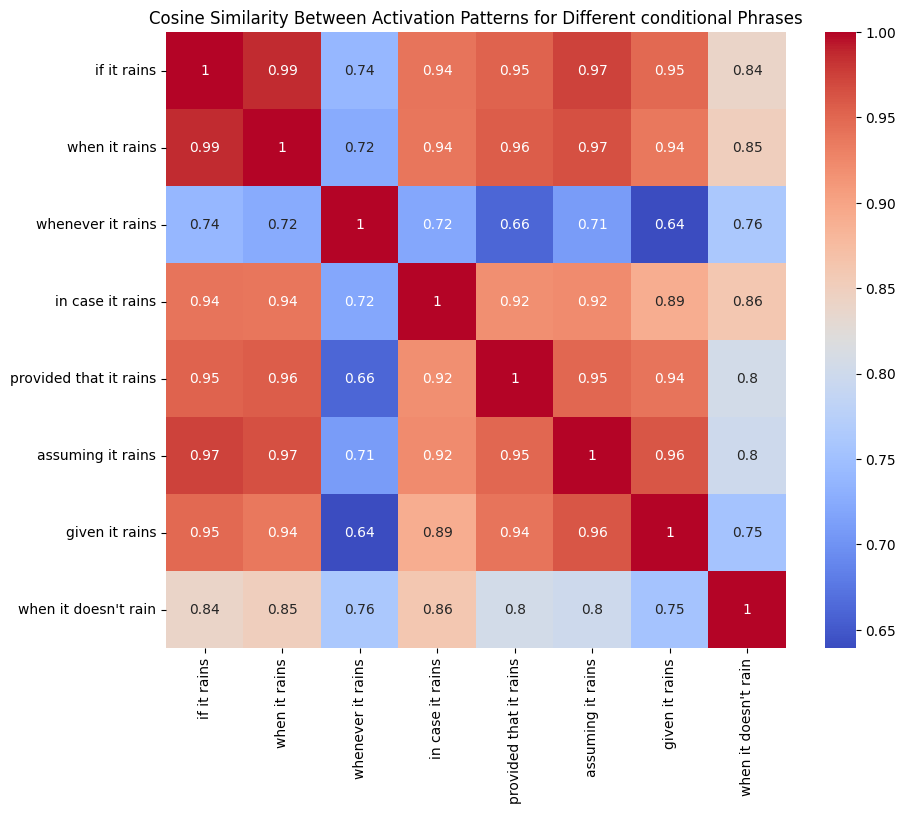

In [46]:
from transformers import AutoTokenizer, AutoModel
import torch

# Define permutations of the phrase
conditional_phrases = [
    "if it rains", "when it rains", "whenever it rains", "in case it rains",
    "provided that it rains", "assuming it rains", "given it rains", "when it doesn't rain"
]

verb_phrases = [
    "uses an umbrella", "makes use of an umbrella", "takes an umbrella",
    "carries an umbrella", "grabs an umbrella", "holds an umbrella", "picks up an umbrella"
]

# Construct sentences
sentences = [f"{phrase}, Mary uses an umbrella. It rains today, so Mary uses an" for phrase in phrases]

sentences_verb = [f"If it rains, Mary {phrase}." for phrase in verb_phrases]


# Tokenize sentences and obtain model outputs
results = []

#change the sentences variable to see how similar the phrases are 
for sentence in sentences: 
    # Tokenize the permutation and obtain logits
    tokens = fine_tuned_model.to_tokens(sentence)
    logits = fine_tuned_model(tokens, return_type="logits")
    print(logits)
    # Extract the logits for the phrase
    # Assume the phrase is at the start of the sentence, so we take the first few tokens
    token_length = len(tokenizer.tokenize(verb_phrases[0]))
    phrase_logits = logits[:, 1:token_length+1]  
    results.append(phrase_logits.mean(dim=1)) 

from sklearn.metrics.pairwise import cosine_similarity

# Stack the results to create a matrix suitable for similarity computation
logits_matrix = torch.cat(results, dim=0).detach().numpy()
similarity_matrix = cosine_similarity(logits_matrix)

# Plot the similarity matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm',
            xticklabels=conditional_phrases, yticklabels=conditional_phrases)  # Use the correct phrases list
plt.title("Cosine Similarity Between Activation Patterns for Different conditional Phrases")
plt.show()


##Circuits: causal scrubbing

##activation patching

##Sparse Autoencoders

In [ ]:
custom_model_dir = "/Users/crayhippo/deduct/LogiQA2.0/weights/fine_tuned_model_final.pth"

#store state_dictionary
state_dict = torch.load(custom_model_dir, map_location=torch.device('cpu'))

# Initialize the new structured state_dict
structured_state_dict = {
    "embed": {
        "W_E": state_dict['embed.W_E'].tolist()  # Convert tensor to list if saving to JSON
    },
    "pos_embed": {
        "W_pos": state_dict['pos_embed.W_pos'].tolist()
    },
    "blocks": [],
    "unembed": {
        "W_U": state_dict['unembed.W_U'].tolist(),
        "b_U": state_dict['unembed.b_U'].tolist()
    }
}

# Populate the blocks array
num_blocks = 12  # or dynamically determine this from state_dict keys
for i in range(num_blocks):
    block_key_prefix = f"blocks.{i}"
    block_data = {
        "attn": {
            "W_Q": state_dict[f'{block_key_prefix}.attn.W_Q'].tolist(),
            "W_O": state_dict[f'{block_key_prefix}.attn.W_O'].tolist(),
            "b_Q": state_dict[f'{block_key_prefix}.attn.b_Q'].tolist(),
            "b_O": state_dict[f'{block_key_prefix}.attn.b_O'].tolist(),
            "W_K": state_dict[f'{block_key_prefix}.attn.W_K'].tolist(),
            "W_V": state_dict[f'{block_key_prefix}.attn.W_V'].tolist(),
            "b_K": state_dict[f'{block_key_prefix}.attn.b_K'].tolist(),
            "b_V": state_dict[f'{block_key_prefix}.attn.b_V'].tolist(),
            "mask": state_dict.get(f'{block_key_prefix}.attn.mask', None).tolist() if state_dict.get(f'{block_key_prefix}.attn.mask', None) is not None else None
        },
        "mlp": {
            "W_in": state_dict[f'{block_key_prefix}.mlp.W_in'].tolist(),
            "b_in": state_dict[f'{block_key_prefix}.mlp.b_in'].tolist(),
            "W_out": state_dict[f'{block_key_prefix}.mlp.W_out'].tolist(),
            "b_out": state_dict[f'{block_key_prefix}.mlp.b_out'].tolist(),
        }
    }
    structured_state_dict["blocks"].append(block_data)

structured_state_dict["model_type"] = "gpt2"

with open('/Users/crayhippo/deduct/LogiQA2.0/weights/formatted_model_state.json', 'w') as f:
    json.dump(structured_state_dict, f, indent=4)
    print("json file created and model state dumped")

In [ ]:
with open("/Users/crayhippo/deduct/LogiQA2.0/logiqa2nli/data/QA2NLI/formatted_model_state.json", "r") as file:
    state_dict_json = [json.loads(line) for line in file]

assert state_dict_json.contains['model_type']

In [62]:
formatted_model_state_dir = "/Users/crayhippo/deduct/LogiQA2.0/logiqa2nli/data/QA2NLI/formatted_model_state.json"
model_nnsight = LanguageModel(formatted_model_state_dir, tokenizer=tokenizer)

ValueError: Unrecognized model in /Users/crayhippo/deduct/LogiQA2.0/logiqa2nli/data/QA2NLI/formatted_model_state.json. Should have a `model_type` key in its config.json, or contain one of the following strings in its name: albert, align, altclip, audio-spectrogram-transformer, autoformer, bark, bart, beit, bert, bert-generation, big_bird, bigbird_pegasus, biogpt, bit, blenderbot, blenderbot-small, blip, blip-2, bloom, bridgetower, bros, camembert, canine, chinese_clip, chinese_clip_vision_model, clap, clip, clip_vision_model, clipseg, clvp, code_llama, codegen, cohere, conditional_detr, convbert, convnext, convnextv2, cpmant, ctrl, cvt, data2vec-audio, data2vec-text, data2vec-vision, deberta, deberta-v2, decision_transformer, deformable_detr, deit, depth_anything, deta, detr, dinat, dinov2, distilbert, donut-swin, dpr, dpt, efficientformer, efficientnet, electra, encodec, encoder-decoder, ernie, ernie_m, esm, falcon, fastspeech2_conformer, flaubert, flava, fnet, focalnet, fsmt, funnel, fuyu, gemma, git, glpn, gpt-sw3, gpt2, gpt_bigcode, gpt_neo, gpt_neox, gpt_neox_japanese, gptj, gptsan-japanese, graphormer, groupvit, hubert, ibert, idefics, imagegpt, informer, instructblip, jukebox, kosmos-2, layoutlm, layoutlmv2, layoutlmv3, led, levit, lilt, llama, llava, llava_next, longformer, longt5, luke, lxmert, m2m_100, mamba, marian, markuplm, mask2former, maskformer, maskformer-swin, mbart, mctct, mega, megatron-bert, mgp-str, mistral, mixtral, mobilebert, mobilenet_v1, mobilenet_v2, mobilevit, mobilevitv2, mpnet, mpt, mra, mt5, musicgen, musicgen_melody, mvp, nat, nezha, nllb-moe, nougat, nystromformer, oneformer, open-llama, openai-gpt, opt, owlv2, owlvit, patchtsmixer, patchtst, pegasus, pegasus_x, perceiver, persimmon, phi, pix2struct, plbart, poolformer, pop2piano, prophetnet, pvt, pvt_v2, qdqbert, qwen2, rag, realm, reformer, regnet, rembert, resnet, retribert, roberta, roberta-prelayernorm, roc_bert, roformer, rwkv, sam, seamless_m4t, seamless_m4t_v2, segformer, seggpt, sew, sew-d, siglip, siglip_vision_model, speech-encoder-decoder, speech_to_text, speech_to_text_2, speecht5, splinter, squeezebert, stablelm, starcoder2, superpoint, swiftformer, swin, swin2sr, swinv2, switch_transformers, t5, table-transformer, tapas, time_series_transformer, timesformer, timm_backbone, trajectory_transformer, transfo-xl, trocr, tvlt, tvp, udop, umt5, unispeech, unispeech-sat, univnet, upernet, van, videomae, vilt, vipllava, vision-encoder-decoder, vision-text-dual-encoder, visual_bert, vit, vit_hybrid, vit_mae, vit_msn, vitdet, vitmatte, vits, vivit, wav2vec2, wav2vec2-bert, wav2vec2-conformer, wavlm, whisper, xclip, xglm, xlm, xlm-prophetnet, xlm-roberta, xlm-roberta-xl, xlnet, xmod, yolos, yoso

In [ ]:
print(model_nnsight)

TL saves as a HookedTrasnformer object
nnsight saves as a LanguageModel object.
duh

In [50]:
print("are the models the same?", )
print("dtype of HookedTransformer", type(fine_tuned_model))
print("dtype of nnsight model", type(model_nnsight))

are the models the same?
dtype of HookedTransformer <class 'transformer_lens.HookedTransformer.HookedTransformer'>
dtype of nnsight model <class 'nnsight.models.LanguageModel.LanguageModel'>


Hidden state Exposal

We will try to extract hidden state using both nn sight and TL. We'll know it's right when we check with two diff microscopes...

In [45]:
with model_nnsight.trace("If it rains, Mary uses an Umbrella. It's raining today, so Mary uses an") as tracer:
    hidden_states = model.transformer.h[-1].output[0].save()

TypeError: HookedTransformer.forward() got an unexpected keyword argument 'input_ids'